In [1]:
import numpy as np
import gpflow as gpf
from gpflow.utilities import print_summary
from gpflow.ci_utils import reduce_in_tests
from data.mocap import MocapDataset
import  torch
import seaborn as sns
from scipy.cluster.vq import kmeans

2023-08-25 11:08:13.640559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
sensors_names = ['root','lowerback','upperback','thorax','lowerneck','upperneck','head','rclavicle','rhumerus','rradius','rwrist','rhand','rfingers','rthumb','lclavicle','lhumerus','lradius','lwrist','lhand','lfingers','lthumb','rfemur','rtibia','rfoot','rtoes','lfemur','ltibia','lfoot','ltoes']
sensors_measures = [6,3,3,3,3,3,3,2,3,1,1,2,1,2,2,3,1,1,2,1,2,3,1,2,1,3,1,2,1]
s_names_measures = []
for i, sensor_name in enumerate(sensors_names):
  s_names_measures.append([sensor_name] * sensors_measures[i])
mask = [31, 32, 33, 34, 35, 43, 44, 45, 46, 47, 54, 61]
mask_sensors_names = [11,12,13,18,19,20,24,28]
s_names_measures = np.array([item for s_names_measures in s_names_measures for item in s_names_measures])
s_names_measures_50 = np.delete(s_names_measures, mask, 0).tolist()
s_sep_50 = np.cumsum(np.delete(np.array(sensors_measures), mask_sensors_names, 0))
sensors_measures_21 = np.insert(s_sep_50, 0, 0)
sensors_names_21 = list(dict.fromkeys(s_names_measures_50))

In [757]:
for i, name in enumerate(s_names_measures_50):
    print(name,i)

root 0
root 1
root 2
root 3
root 4
root 5
lowerback 6
lowerback 7
lowerback 8
upperback 9
upperback 10
upperback 11
thorax 12
thorax 13
thorax 14
lowerneck 15
lowerneck 16
lowerneck 17
upperneck 18
upperneck 19
upperneck 20
head 21
head 22
head 23
rclavicle 24
rclavicle 25
rhumerus 26
rhumerus 27
rhumerus 28
rradius 29
rwrist 30
lclavicle 31
lclavicle 32
lhumerus 33
lhumerus 34
lhumerus 35
lradius 36
lwrist 37
rfemur 38
rfemur 39
rfemur 40
rtibia 41
rfoot 42
rfoot 43
lfemur 44
lfemur 45
lfemur 46
ltibia 47
lfoot 48
lfoot 49


# Coregionalized kernel for Multi-Task GP

In [803]:
data_seqlen = 100
data_subject = '09'
data_full = MocapDataset(data_path='data/mocap', subject=data_subject, pca_components=-1, data_normalize=False, dt=0.01, seqlen=data_seqlen)
train_ys_full = torch.tensor(data_full.trn.ys)
train_ts = torch.tensor(data_full.trn.ts)

In [804]:
X = np.float64(train_ts.numpy()) # Time instants
T = X.shape[0]
Y = np.float64(train_ys_full[0, :, :].numpy()) # Take only first sequence
P = Y.shape[1]

In [805]:
P = 6
Y = Y[:,np.array([15,18,26,29,30,33])]#36,37,41,42,47,48
sensors = ['lowerneck', 'upperneck','rhumerus', 'rradius', 'rwrist', 'lhumerus', 'lradius', 'lwrist', 'rtibia', 'rfoot', 'ltibia', 'lfoot']

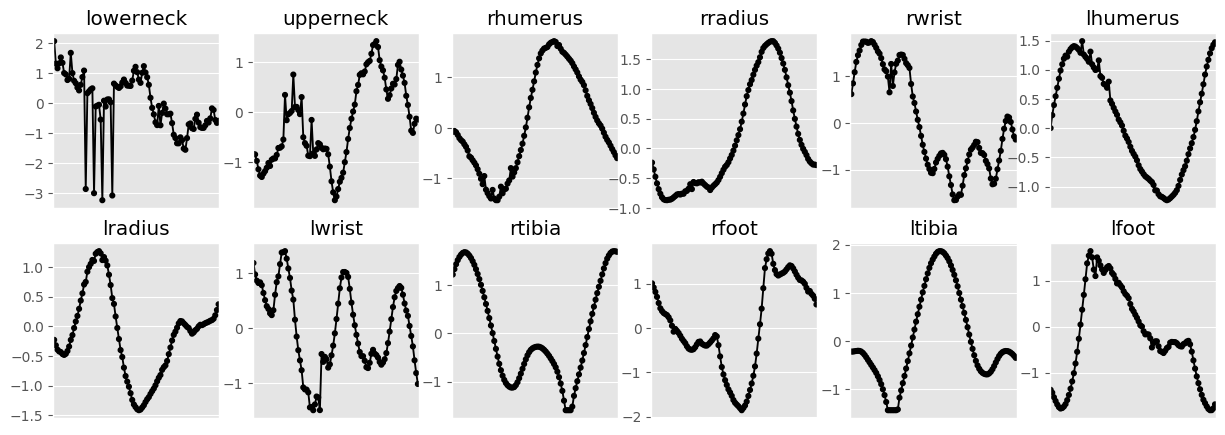

In [799]:
fig, axs = plt.subplots(2, 6, figsize=(15, 5))
k = 0
for i in range(2):
    for j in range(6):
        sns.pointplot(x=X, y=Y[:,k], join=True, scale=0.5, color='black', ax=axs[i,j])
        axs[i,j].set_xticks([])
        axs[i,j].set_title('%s'%sensors[k])
        k += 1

In [806]:
# Augment the input with ones or zeros to indicate the required output dimension
X_rep = np.tile(X.reshape(-1,1), (P,1))
indices = np.repeat(np.arange(P), 100).reshape(-1,1)
X_augmented = np.hstack((X_rep, indices))
# Augment the Y data
Y_augmented = np.hstack((np.vstack([Y[:, i].reshape(-1, 1) for i in range(P)]), indices))

print('X_augmented: ', X_augmented.shape)
print('Y_augmented: ', Y_augmented.shape)

X_augmented:  (600, 2)
Y_augmented:  (600, 2)


In [807]:
output_dim = P  # Number of outputs
rank = P  # Rank of W
# Base kernel
k = gpflow.kernels.SquaredExponential(1, active_dims=[0])
# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])
kern = k * coreg
coreg.W = np.random.rand(P, 1)

In [808]:
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian()]*P)
# define inducing locations
M = 10 # num inducing points 
Z = np.linspace(0, 0.99, M)[:, None]#kmeans(X_augmented, num_inducing)[0]
Z_augmented = np.hstack((np.tile(Z.reshape(-1,1), (P,1)), np.repeat(np.arange(P), M).reshape(-1,1)))
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z_augmented)
)
# now build the GP model as normal
m = gpflow.models.VGP(data=(X_augmented, Y_augmented), kernel=kern, likelihood=lik, num_latent_gps=1)
#kernel_multioutput = gpf.kernels.SharedIndependent(kern, output_dim=P)
#m = gpf.models.SVGP(kernel_multioutput, lik, inducing_variable=iv, num_latent_gps=1)
print_summary(m)
# fit the covariance function parameters

maxiter = reduce_in_tests(1000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables,
    options={"disp": 50, "maxiter": reduce_in_tests(1000)},
    method="L-BFGS-B",
)
# 8min (not normalize, matern)
"""
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure((X_augmented, Y_augmented)),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": 50, "maxiter": reduce_in_tests(1000)},
    )
optimize_model_with_scipy(m)
"""

╒════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════╕
│ name                                   │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value            │
╞════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════╡
│ VGP.kernel.kernels[0].variance         │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 1.0              │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────┤
│ VGP.kernel.kernels[0].lengthscales     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 1.0              │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────┤

 This problem is unconstrained.



At iterate   50    f=  4.99821D+02    |proj g|=  2.81244D+01

At iterate  100    f=  3.70570D+02    |proj g|=  3.26992D+01

At iterate  150    f=  3.15917D+02    |proj g|=  1.82279D+01

At iterate  200    f=  2.99485D+02    |proj g|=  4.04841D+01

At iterate  250    f=  2.92991D+02    |proj g|=  9.72218D+00


KeyboardInterrupt: 

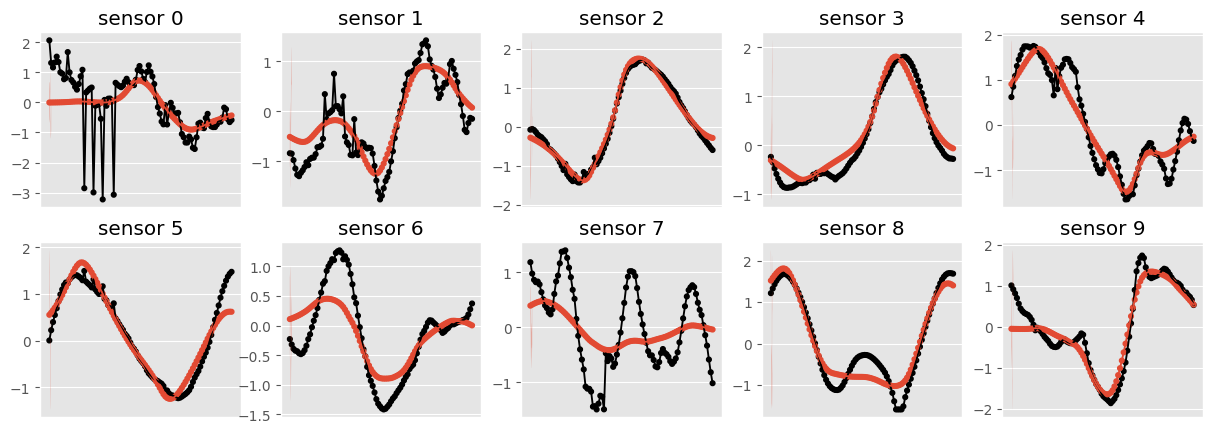

In [776]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(m):
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    Xtest = np.linspace(0, 1, 100)[:, None]
    
    k = 0
    for i in range(2):
        for j in range(5):
            sns.pointplot(x=np.linspace(0, 1, 100), y=Y[:,k], join=True, scale=0.5, color='black', ax=axs[i,j])
            mu, var = m.predict_f(np.hstack((Xtest, k*np.ones_like(Xtest))))
            sns.pointplot(x=np.linspace(0, 1, 100), y=mu[:,0].numpy(), scale=0.5, ax=axs[i,j])
            axs[i,j].fill_between(Xtest[:, 0],(mu - 2 * np.sqrt(var))[:, 0],(mu + 2 * np.sqrt(var))[:, 0],alpha=0.4)
            #plot_gp(Xtest, mu, var, line.get_color(), "Y1")
            axs[i,j].set_xticks([])
            axs[i,j].set_title('%s'%sensors[k])
            k += 1
    """
    (line,) = plt.plot(X, Y[:,0], "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y1")

    (line,) = plt.plot(X, Y[:,1], "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y2")

    (line,) = plt.plot(X, Y[:,2], "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, 2*np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y3")

    (line,) = plt.plot(X, Y[:,3], "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, 3*np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y4")

    (line,) = plt.plot(X, Y[:,4], "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, 4*np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y5")
    """
    plt.show()

plot(m)

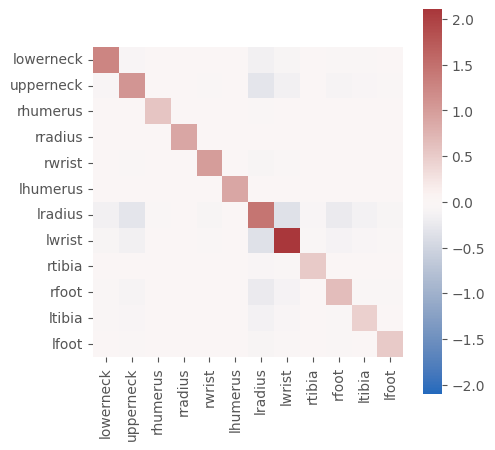

In [784]:
Sigma = coreg.output_covariance().numpy()
Lambda  = np.linalg.inv(Sigma)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(Lambda, annot=False, square=True, cmap='vlag', vmax=np.max(Lambda), vmin=-np.max(Lambda), center=0, ax=ax)
ax.set_xticklabels(sensors)
ax.set_yticklabels(sensors)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=360)
plt.show()

## LMC perspective

In [410]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf

from gpflow.utilities import print_summary
from gpflow.ci_utils import reduce_in_tests

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = reduce_in_tests(2000)

In [420]:
data_seqlen = 100
data_subject = '09_m1'
data_full = MocapDataset(data_path='data/mocap', subject=data_subject, pca_components=-1, data_normalize=True, dt=0.01, seqlen=data_seqlen)
train_ys = torch.tensor(data_full.trn.ys) # 6 x 100 x 21 -> T = 100
test_ys = torch.tensor(data_full.tst.ys) # 2 x 120 x 21
train_ts = torch.tensor(data_full.trn.ts)

In [441]:
s = 0
X = np.float64(train_ts.numpy())[:,None] # T x 1
T = X.shape[0]
# reshape data to merge all sequences
#train_ys =  train_ys.reshape(-1, train_ys.shape[-1])
Y = np.float64(train_ys[s,:,:].numpy()) # T x P
P = Y.shape[1]
M = 10
Zinit = np.linspace(0, 1, M)[:,None]# M x 1, M<<T
L = P

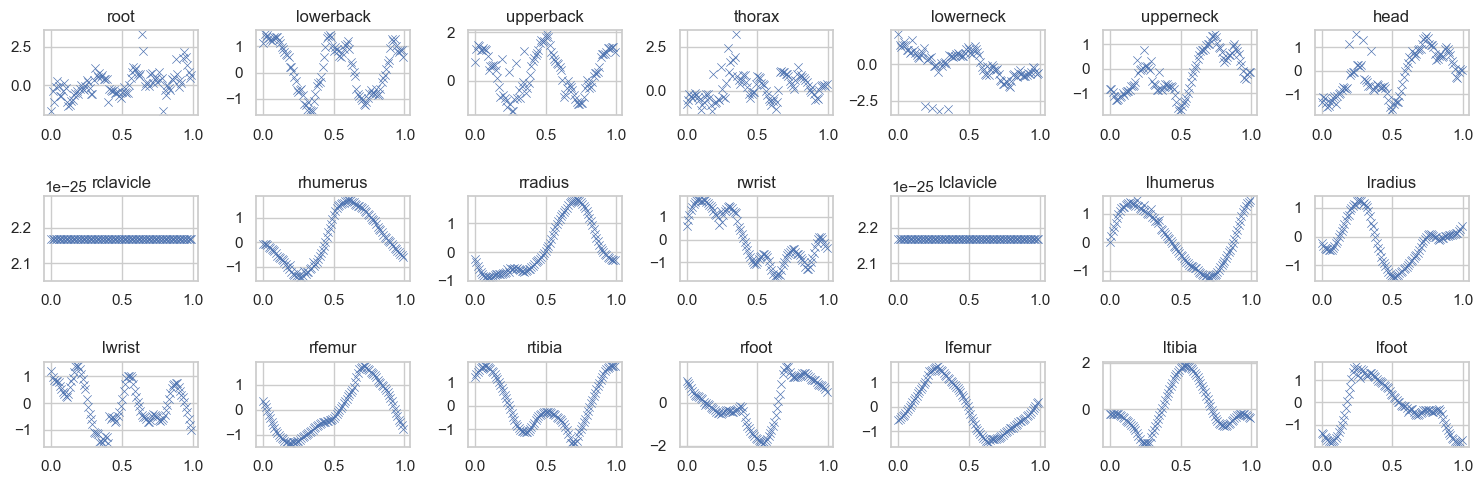

In [442]:
def plot_data():
    sns.set(style="whitegrid")  # Set Seaborn style
    
    fig, axs = plt.subplots(3, 7, figsize=(15, 5))
    k = 0
    for i in range(3):
        for j in range(7): 
            # Seaborn scatter plot for X and Y[:, k]
            sns.scatterplot(x=X.flatten(), y=Y[:,k], ax=axs[i, j], marker="x")
            
            axs[i, j].set_title('%s' % sensors_names_21[k])  # Set the title  
            k += 1
    
    plt.tight_layout()  # Adjust layout
    plt.show()

plot_data()


In [443]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() for _ in range(L)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.LinearCoregionalization(
    kern_list, W=np.random.randn(P, L)
)  # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [445]:
# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

# create SVGP model as usual and optimize
m = gpf.models.SVGP(
    kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, q_mu=q_mu, q_sqrt=q_sqrt
)

In [446]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure((X,Y)),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": 1000},
    )
optimize_model_with_scipy(m)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1859     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29681D+04    |proj g|=  1.26351D+04

At iterate    1    f=  1.28216D+04    |proj g|=  4.67717D+03

At iterate    2    f=  8.95217D+03    |proj g|=  5.76861D+03

At iterate    3    f=  5.25971D+03    |proj g|=  1.15730D+03

At iterate    4    f=  4.66882D+03    |proj g|=  7.89006D+02

At iterate    5    f=  4.02675D+03    |proj g|=  2.69558D+02

At iterate    6    f=  3.83755D+03    |proj g|=  1.53790D+02

At iterate    7    f=  3.74826D+03    |proj g|=  4.66233D+02


 This problem is unconstrained.



At iterate    8    f=  3.67341D+03    |proj g|=  2.66485D+02

At iterate    9    f=  3.35801D+03    |proj g|=  5.87673D+02

At iterate   10    f=  3.26564D+03    |proj g|=  4.93002D+02

At iterate   11    f=  2.99388D+03    |proj g|=  2.54917D+02

At iterate   12    f=  2.89924D+03    |proj g|=  9.58343D+02

At iterate   13    f=  2.87428D+03    |proj g|=  2.32447D+02

At iterate   14    f=  2.82949D+03    |proj g|=  6.86115D+02

At iterate   15    f=  2.82276D+03    |proj g|=  3.23215D+02

At iterate   16    f=  2.80913D+03    |proj g|=  3.04647D+02

At iterate   17    f=  2.80361D+03    |proj g|=  2.24604D+02

At iterate   18    f=  2.76348D+03    |proj g|=  1.14188D+02

At iterate   19    f=  2.74268D+03    |proj g|=  1.33834D+02

At iterate   20    f=  2.72577D+03    |proj g|=  6.06008D+01

At iterate   21    f=  2.71123D+03    |proj g|=  2.21863D+02

At iterate   22    f=  2.70109D+03    |proj g|=  1.59633D+02

At iterate   23    f=  2.69034D+03    |proj g|=  7.02631D+01

At iter

In [447]:
mean, var = m.predict_f(X)

<AxesSubplot: >

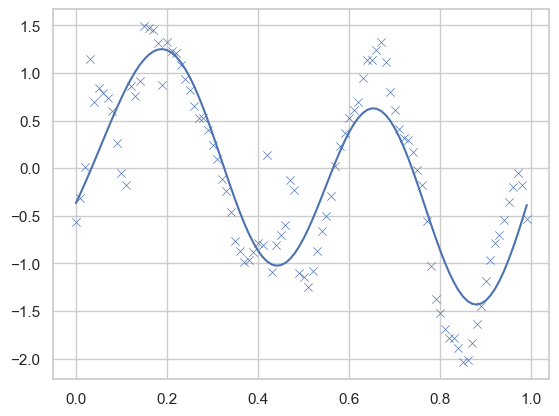

In [438]:
k = 2
sns.scatterplot(x=X.flatten(), y=Y[:,k], marker="x")
sns.lineplot(x=X.flatten(), y=mean[:,k])

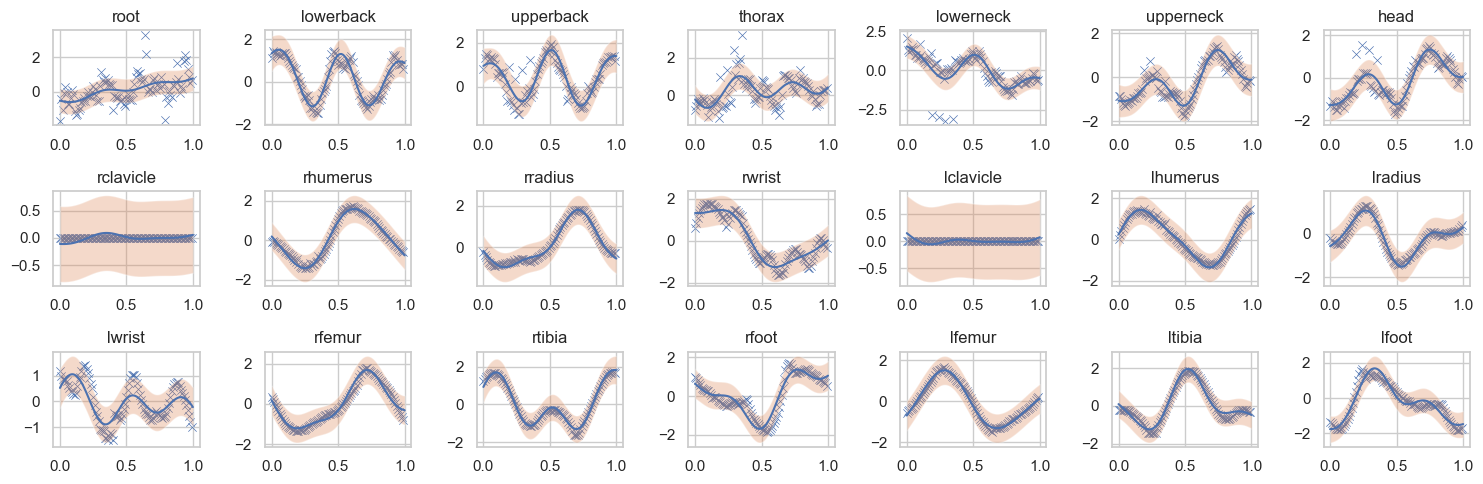

In [448]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined `m`, `X`, `Y`, `Z`, and `sensors` somewhere

def plot_model(m, lower=-1.0, upper=2.0):
    sns.set(style="whitegrid")  # Set Seaborn style
    
    fig, axs = plt.subplots(3, 7, figsize=(15, 5))
    Xtest = np.linspace(0, 1, 100)[:, None]
    pY, pYv = m.predict_y(Xtest) # TxP
    k = 0
    for i in range(3):
        for j in range(7): 
            # Seaborn scatter plot for X and Y[:, k]
            sns.scatterplot(x=X.flatten(), y=Y[:, k], ax=axs[i, j], marker="x")
            
            # Seaborn line plot for Xtest and pY[:, k]
            sns.lineplot(x=Xtest.flatten(), y=pY[:, k], ax=axs[i, j])
            
            axs[i, j].set_title('%s' % sensors_names_21[k])  # Set the title
            
            top = pY[:, k] + 2.0 * pYv[:, k] ** 0.5
            bot = pY[:, k] - 2.0 * pYv[:, k] ** 0.5
            
            # Fill between for uncertainty
            axs[i, j].fill_between(Xtest[:, 0], top, bot, alpha=0.3)
            
            #axs[i, j].plot(Z, Z * 0.0, "o")
            k += 1
    
    plt.tight_layout()  # Adjust layout
    plt.show()

plot_model(m)


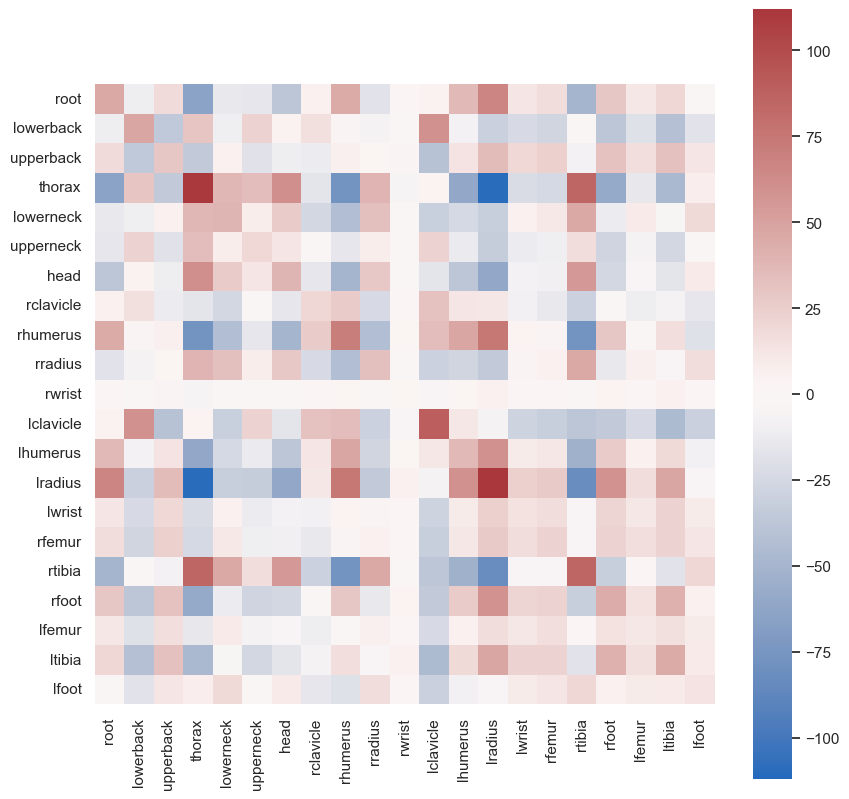

In [449]:
sensors_names_21 = list(dict.fromkeys(s_names_measures_50))
Sigma = m.kernel.W.numpy()  @  m.kernel.W.numpy().T
Lambda = np.linalg.inv(Sigma)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(Lambda, annot=False, square=True, cmap='vlag', vmax=np.max(Lambda), vmin=-np.max(Lambda), center=0, ax=ax)
ax.set_xticklabels(sensors_names_21)
ax.set_yticklabels(sensors_names_21)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=360)
plt.show()

In [404]:
data_seqlen = 100
data_subject = '09_m1'
data_full = MocapDataset(data_path='data/mocap', subject=data_subject, pca_components=-1, data_normalize=False, dt=0.01, seqlen=data_seqlen)
train_ys = torch.tensor(data_full.trn.ys) # 6 x 100 x 21 -> T = 100
test_ys = torch.tensor(data_full.tst.ys) # 2 x 120 x 21
train_ts = torch.tensor(data_full.trn.ts)

In [405]:
X = np.float64(train_ts.numpy()) # T x 1
X = np.tile(X, (6,1)).reshape(6,100,1)
T = X.shape[0]
# reshape data to merge all sequences
#train_ys =  train_ys.reshape(-1, train_ys.shape[-1])
Y = np.float64(train_ys.numpy()) # S x T x P
P = Y.shape[2]
L = P

In [406]:
import numpy as np
import gpflow

# Define a kernel suitable for batched input
kern_list = [gpf.kernels.SquaredExponential() for _ in range(L)]
kernel = gpf.kernels.LinearCoregionalization(kern_list, W=np.random.randn(P, L))
# Define inducing points
M = 100
Zinit = np.linspace(0,1,M)[:,None]  # Assuming you have Zinit defined
Z = Zinit.copy()
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)
# LMC initialization
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0
# Create an SVGP model

model = gpflow.models.SVGP(kernel=kernel, 
                           likelihood=gpflow.likelihoods.Gaussian(),
                           inducing_variable=iv,
                           q_mu=q_mu, q_sqrt=q_sqrt)
                           #num_latent_gps=num_output_dimensions)

# Optimize the model
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure((X,Y)),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": 2000},
    )

optimize_model_with_scipy(model)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       108734     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53851D+05    |proj g|=  8.59510D+04


 This problem is unconstrained.



At iterate    1    f=  8.52723D+04    |proj g|=  3.21583D+04

At iterate    2    f=  6.42071D+04    |proj g|=  1.79236D+04

At iterate    3    f=  3.16129D+04    |proj g|=  6.70548D+03

At iterate    4    f=  2.67972D+04    |proj g|=  1.06173D+03

At iterate    5    f=  2.34741D+04    |proj g|=  1.74993D+03

At iterate    6    f=  2.25877D+04    |proj g|=  9.48630D+03

At iterate    7    f=  2.25262D+04    |proj g|=  2.12420D+03

At iterate    8    f=  2.23965D+04    |proj g|=  2.52358D+03

At iterate    9    f=  2.22704D+04    |proj g|=  1.06848D+03

At iterate   10    f=  2.21456D+04    |proj g|=  1.81543D+03

At iterate   11    f=  2.18012D+04    |proj g|=  1.99650D+03

At iterate   12    f=  2.12421D+04    |proj g|=  1.50307D+03

At iterate   13    f=  2.04933D+04    |proj g|=  1.44981D+03

At iterate   14    f=  1.97690D+04    |proj g|=  1.20186D+03

At iterate   15    f=  1.88732D+04    |proj g|=  1.53865D+03

At iterate   16    f=  1.84845D+04    |proj g|=  1.47385D+03

At iter

In [407]:
mean, var = model.predict_f(X[0])

In [408]:
mean.shape

TensorShape([100, 21])

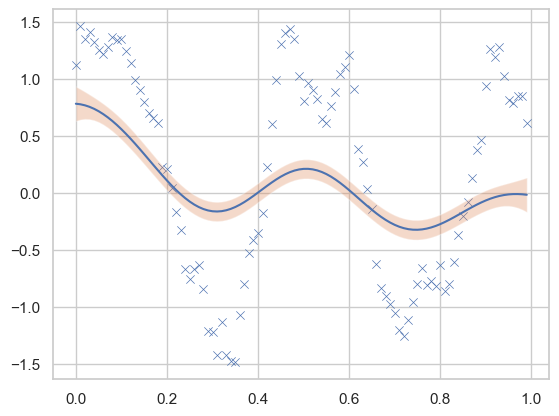

In [409]:
k = 1
sns.scatterplot(x=X[0].flatten(), y=Y[0,:,k], marker="x")
sns.lineplot(x=X[0].flatten(), y=mean[:,k])
top = mean[:,k] + 2.0 * var[:,k] ** 0.5
bot = mean[:,k] - 2.0 * var[:,k] ** 0.5
plt.fill_between(X[0,:,0], top, bot, alpha=0.3)

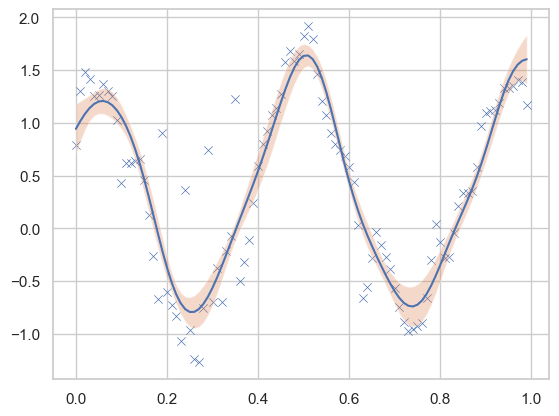

In [362]:
k = 2
sns.scatterplot(x=X[0].flatten(), y=Y[0,:,k], marker="x")
sns.lineplot(x=X[0].flatten(), y=mean[0,:,k])
top = mean[0,:,k] + 2.0 * var[0,:,k] ** 0.5
bot = mean[0,:,k] - 2.0 * var[0,:,k] ** 0.5
plt.fill_between(X[0,:,0], top, bot, alpha=0.3)

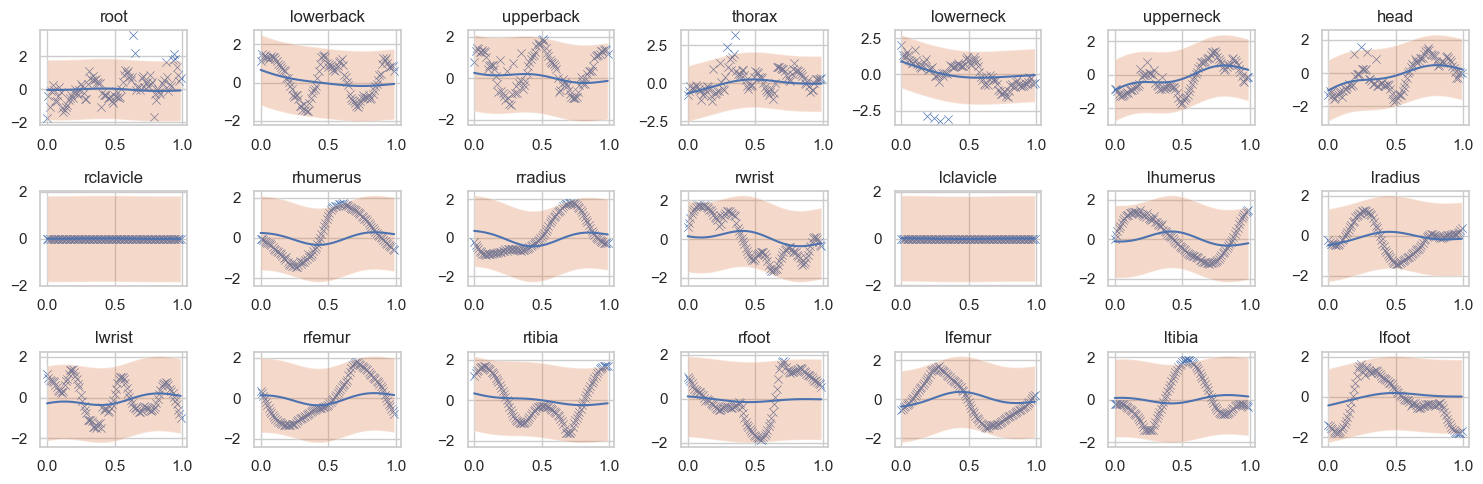

In [386]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined `m`, `X`, `Y`, `Z`, and `sensors` somewhere

def plot_model(m, lower=-1.0, upper=2.0):
    sns.set(style="whitegrid")  # Set Seaborn style
    
    fig, axs = plt.subplots(3, 7, figsize=(15, 5))
    mean, var = m.predict_y(X) # TxP
    k = 0
    for i in range(3):
        for j in range(7): 
            # Seaborn scatter plot for X and Y[:, k]
            sns.scatterplot(x=X[0].flatten(), y=Y[0,:,k], ax=axs[i, j], marker="x")
            
            # Seaborn line plot for Xtest and pY[:, k]
            sns.lineplot(x=X[0].flatten(), y=mean[0,:,k], ax=axs[i, j])
            
            axs[i, j].set_title('%s' % sensors_names_21[k])  # Set the title  
            top = mean[0,:,k] + 2.0 * var[0,:,k] ** 0.5
            bot = mean[0,:,k] - 2.0 * var[0,:,k] ** 0.5
            axs[i, j].fill_between(X[0,:,0], top, bot, alpha=0.3)
            k += 1
    
    plt.tight_layout()  # Adjust layout
    plt.show()

plot_model(model)
